# 02807 Computational Tools for Data Science - Book recomendation system 

# Introduction
The notebook first loads two dataframes, one containing data for each book, and one containing reviews of the books.

Then the data is cleaned.

Furthermore, different methods are used to recommend books.



<a id="0"></a> <br>

# Table of Contents  

* [Data](#data)    

* [Models](#models)

    * [Jaccard similarity on book data ](#model1)

    *


In [1]:
%env VARIABLE=comptools-env

env: VARIABLE=comptools-env


### Load packages

In [2]:
import pandas as pd
import numpy as np
import mmh3

import matplotlib.pyplot as plt
import seaborn as sns

<a id="data"></a> <br>
# Data


In [3]:
books_data = pd.read_csv('data/books_data.csv') #, nrows=1000)
print(f"Books data has " + str(books_data.columns.size) + " columns with " + str(books_data.shape[0]) + " rows each.")
books_ratings = pd.read_csv('data/books_rating.csv') #, nrows=1000)
print(f"Books ratings has " + str(books_ratings.columns.size) + " columns with " + str(books_ratings.shape[0]) + " rows each.")

Books data has 10 columns with 212404 rows each.
Books ratings has 10 columns with 3000000 rows each.


## Data Preprocessing
The following section cleans the data. 
This is done with the following steps

- We remove columns that we do not use and rename some of the columns.
- We change "&" to "and", remove special characters in the titles, and make titles lower case. This is done for both data sets.
- We remove dublicates of titles and descriptions.
- We remove duplicate reviews where same user reviews same book multiple times.
- We then remove reviews where title is NaN.
- Remove books with less than 10 reviews.
- Remove users with less than 20 reviews.
- Add column to book_data: average_rating and helpfullness of reviews to books_ratings

The data cleaning is now complete and we can go to the first model.

In [4]:
# Titles
books_data_1 = books_data.drop(['image', 'previewLink', 'infoLink', 'publisher', 'ratingsCount'], axis=1, inplace=False)
books_ratings_1 = books_ratings.drop(['Id','Price', 'profileName', 'review/time'], axis=1, inplace=False)

books_data_1.rename(columns={'Title': 'title','publishedDate': 'published_date'}, inplace=True)
books_ratings_1.rename(columns={'Title': 'title','User_id':'user_id',  'review/score': 'score','review/helpfulness': 'helpfulness', 'review/text': 'text', 'review/summary': 'summary'}, inplace=True)
print(f"Books data now only has " + str(books_data_1.columns.size) + " columns - " + str(list(books_data_1.columns)))
print(f"Books ratings now only has " + str(books_ratings_1.columns.size) + " columns - " + str(list(books_ratings_1.columns))) 


Books data now only has 5 columns - ['title', 'description', 'authors', 'published_date', 'categories']
Books ratings now only has 6 columns - ['title', 'user_id', 'helpfulness', 'score', 'summary', 'text']


In [5]:
#Makes all titles lowercase; then removes any part of the title that includes a parenthesis, and replaces any ampersands with 'and'
books_data_1['title'] = books_data_1['title'].map(lambda s: s.lower() if type(s) == str else s)
books_data_1['title'] = books_data_1['title'].replace(r"\(.*\)","", regex=True)
books_data_1['title'] = books_data_1['title'].replace(r"\&","and", regex=True)

books_ratings_1['title'] = books_ratings_1['title'].map(lambda s: s.lower() if type(s) == str else s)
books_ratings_1['title'] = books_ratings_1['title'].replace(r"\(.*\)","", regex=True)
books_ratings_1['title'] = books_ratings_1['title'].replace(r"\&","and", regex=True)

#Removes any characters that aren't letters or spaces.
books_data_1['title'] = books_data_1['title'].replace(r"[^a-zA-Z0-9\s]+", "", regex=True)
books_ratings_1['title'] = books_ratings_1['title'].replace(r"[^a-zA-Z0-9\s]+", "", regex=True)

print("Both datasets' titles are now all lowercase and only include letters and spaces.")


Both datasets' titles are now all lowercase and only include letters and spaces.


In [6]:
# keep only unique titles in books_data_1
#size of books_data_1
prev_size = len(books_data_1['title'])
print(f"Books data has " + str(len(books_data_1['title'])) + " titles.")
books_data_1 = books_data_1.drop_duplicates(subset=['title'], keep='first')
books_data_1 = books_data_1.drop_duplicates(subset=['description'], keep='first')
print(f"Dropped " + str(prev_size - len(books_data_1['title'])) + " duplicate titles and descriptions. Now there are only " + str(len(books_data_1['title'])) + " rows left. ")

Books data has 212404 titles.
Dropped 80758 duplicate titles and descriptions. Now there are only 131646 rows left. 


In [7]:
#Drop duplicate reviews where same user reviews same book multiple times
print(f"Books ratings has " + str(len(books_ratings_1['title'])) + " rows.")
prevRatings = len(books_ratings_1['title'])
books_ratings_1.drop_duplicates(keep='first', inplace=True)
print(f"Dropped based on total duplicity. Books ratings now has " + str(len(books_ratings_1['title'])) + " rows. " + " -" + str(prevRatings-len(books_ratings_1['title'])) + " rows.")
prevRatings = len(books_ratings_1['title'])
books_ratings_1.drop_duplicates(subset=['user_id', 'title'], keep='first', inplace=True)
print(f"Dropped based on duplicate title. Books ratings now has " + str(len(books_ratings_1['title'])) + " rows. " + " -" + str(prevRatings-len(books_ratings_1['title'])) + " rows.")
prevRatings = len(books_ratings_1['title'])
books_ratings_1.drop_duplicates(subset=['user_id', 'text'], keep='first', inplace=True)
print(f"Dropped based on duplicate text. Books ratings now has " + str(len(books_ratings_1['title'])) + " rows. " + " -" + str(prevRatings-len(books_ratings_1['title'])) + " rows.")


Books ratings has 3000000 rows.
Dropped based on total duplicity. Books ratings now has 2432035 rows.  -567965 rows.
Dropped based on duplicate title. Books ratings now has 2027318 rows.  -404717 rows.
Dropped based on duplicate text. Books ratings now has 1748116 rows.  -279202 rows.


In [8]:
#Remove NAN titles
print(f"" + str(books_ratings_1.isnull().sum().sum()) + " total NAN values present in title")
books_ratings_1 = books_ratings_1.dropna(subset=['title'])
print(f"Now there are " + str(books_ratings_1.isnull().sum().sum()))

print(f"Now there are " + str(books_data_1.isnull().sum().sum()))

71515 total NAN values present in title
Now there are 71495
Now there are 7172


In [9]:
#Collect only ratings for books that have received at least 10 ratings.
#Add a new column in books_data_1 that counts the number of ratings for each book with a score of at least 10

#Note that by removing duplicate reviews first, counting the number of reviews for each book afterward will be more accurate.
print(f"Books_ratings has " + str(len(books_ratings_1['title'])) + " rows.")
prev_rows = len(books_ratings_1['title'])

n_ratings = books_ratings_1.groupby('title').count()['score']>=10
famous_books = n_ratings[n_ratings==True].index
books_ratings_1 = books_ratings_1[books_ratings_1['title'].isin(famous_books)]
n_ratings_1 = books_ratings_1['title'].value_counts().rename("n_ratings")
books_data_1 = books_data_1.merge(n_ratings_1, on='title', how='inner')

print(f"Books_ratings now has " + str(len(books_ratings_1['title'])) + " rows. -" + str(prev_rows - len(books_ratings_1['title'])) + " rows. ")
print(f"Books_data now has an additional column. (n_ratings)")

#purge books where n_ratings < 10 (redundant operation)
prevBooks = len(books_data_1['title'])
books_data_1 = books_data_1[books_data_1['n_ratings']>=10]
print(f"Books data has " + str(books_data_1.columns.size) + " columns with " + str(books_data_1.shape[0]) + " rows each." + " -" + str(prevBooks-len(books_data_1['title'])) + " rows.")

Books_ratings has 1748097 rows.
Books_ratings now has 1287419 rows. -460678 rows. 
Books_data now has an additional column. (n_ratings)
Books data has 6 columns with 25743 rows each. -0 rows.


In [10]:
#Remove ratings from users who have rated less than 20 books.
prevRatings = len(books_ratings_1['title'])
x = books_ratings_1.groupby('user_id').count()['score'] >= 20 # since this is what amazon requires before a user can get recommendations
considerable_users = x[x].index
books_ratings_1 = books_ratings_1[books_ratings_1['user_id'].isin(considerable_users)]

print(f"Books ratings has " + str(books_ratings_1.columns.size) + " columns with " + str(books_ratings_1.shape[0]) + " rows each." + " -" + str(prevRatings-len(books_ratings_1['title'])) + " rows.")
print(f"" + str(len(books_ratings_1['user_id'].value_counts())) + " users remain who have rated at least 20 books.")

Books ratings has 6 columns with 168980 rows each. -1118439 rows.
3417 users remain who have rated at least 20 books.


In [11]:
# add column in books_data_1 that calculate  the average score of the book.
avg_rating = books_ratings_1.groupby('title')["score"].mean().rename("avg_rating")
books_data_1 = books_data_1.merge(avg_rating, on='title', how='inner')
print(f"Books data now has an additional column. (avg_rating)")

# function to get number of users who found the review helpful
def get_n_helpful(x):
    if isinstance(x, str) and '/' in x:
        num, denom = x.split('/')
        return int(denom)
    else:
        return x

# function to get percentage of users who found the review helpful
def replace_fraction(x):
    if isinstance(x, str) and '/' in x:
        num, denom = x.split('/')
        if denom == '0':
            return 0
        else:
            return int(num) / int(denom)
    else:
        return x

# add columns for number of users who found the review helpful and percentage of users who found the review helpful
books_ratings_1['helpfulness_count'] = books_ratings_1['helpfulness'].apply(get_n_helpful)
books_ratings_1['helpfulness_pct'] = books_ratings_1['helpfulness'].apply(replace_fraction)

Books data now has an additional column. (avg_rating)


<a id="models"></a> <br>

# Recommendation Models

<a id="model1"></a> <br>

## Jaccard Similarity on Books Data


Function jaccard, that takes two titles and outputs the estimated jaccard similarity. \
Function max_jaccard takes a list of titles and compare the titles with each other. It then returns the two titles with the highest jaccard similarity.

In [12]:
def jaccard(title1, title2):
    words1 = set(str(title1).lower().split())
    words2 = set(str(title2).lower().split())
    
    # Compute the intersection and union of the sets
    intersection = len(words1.intersection(words2))
    union = len(words1) + len(words2) - intersection
    
    # Calculate the Jaccard similarity
    similarity = intersection / union if union > 0 else 0.0
    
    return similarity

def max_jaccard(title_list):
    max_similarity = 0.0
    idx1 = 0
    idx2 = 0
    for i in range(len(title_list)):
        for j in range(i + 1, len(title_list)):
            similarity = jaccard(title_list[i], title_list[j])
            if similarity > max_similarity:
                idx1 = i
                idx2 = j
                max_similarity = similarity
    return max_similarity,idx1,idx2

"""
Example usage for comparing two titles
title1 = books_data_1['title'][0]
title2 = books_data_1['title'][1]
print(title1,title2)
similarity = jaccard(title1, title2)
print(f"Jaccard Similarity: {similarity}")
"""

# Example usage with a list of titles
n = 100
title_list = books_data_1['title'][0:n]
max_similarity,idx1,idx2 = max_jaccard(title_list)
print(f"Max Jaccard Similarity: {max_similarity}")
print(books_data_1['title'][idx1])
print(books_data_1['title'][idx2])


Max Jaccard Similarity: 0.4444444444444444
lost cities of africa and arabia 
lost cities of north and central america 


### Similar items using Jaccard similarity

Function for finding similar items yusing jaccard similarity.

In [13]:
def similar(names, jaccard_threshold=0.6):
    # Create a dictionary to store the similar names
    similar_names = {}
    
    # Loop through each name in the list
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            similarity_score = jaccard(names[i], names[j])
            if similarity_score >= jaccard_threshold:
                similar_names[(names[i], names[j])] = similarity_score
    return similar_names

# Example usage:    
names = books_data_1['title'][0:500]
similar_names = similar(names)
# Print titles in a way that is easier to read

for (desc1, desc2), score in similar_names.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {desc1}")
    print(f"Title 2: {desc2}")
    print()


Similarity Score: 0.6
Title 1: the art of the novel
Title 2: the art of loving

Similarity Score: 0.6
Title 1: the holy spirit
Title 2: the baptism with the holy spirit



In [14]:
# Example usage for finding similar descriptions
descritions = books_data_1['description'][0:400]
similar_descriptions = similar(descritions,jaccard_threshold=0.4)

# Print descriptions in a way that is easier to read
for (desc1, desc2), score in similar_descriptions.items():
    print(f"Similarity Score: {score}")
    print(f"Description 1: {desc1}")
    print(f"Description 2: {desc2}")
    print()


Similarity Score: 0.9166666666666666
Description 1: Presents a classic nursery rhyme accompanied by illustrations showing how to form the American Sign Language signs for each word. On board pages.
Description 2: Presents a familiar nursery rhyme accompanied by illustrations showing how to form the American Sign Language signs for each word. On board pages.



### Locality-Sensitive Hashing

Changing to keys for faster computations

In [15]:


names = books_data_1['title'][0:2]
names = names.to_dict()
print(names)

for key, values in names.items():
    print(key)
    print(values)

{0: 'eyewitness travel guide to europe', 1: 'voices from the farm adventures in community living'}
0
eyewitness travel guide to europe
1
voices from the farm adventures in community living


In [16]:
# Function to split words into k parts
def split_k(word,k):
    if word is np.nan:
        return []
    else:
        n = len(word)
    if k > n:
        return split_k(word,int(k/2))
    else:
        if k == 0:
            return word
        n1 = n//k
        n2 = n1 + n%k
        return [word[i:i+n1] for i in range(0, n, n1)]

In [17]:
# Implement the LSH algorithm
b = 10

def lsh(index,names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
       # if i% 1000 == 0:
        #    print(i)
        common_values = np.intersect1d(lsh_dict[list_keys[index]], lsh_dict[list_keys[i]])
        if len(common_values) > 0:
            # we found a candidate
            similarity_score = jaccard(names[index], names[list_keys[i]])
            if similarity_score >= jaccard_threshold:
                similar_items[names[index], list_keys[i]] = similarity_score
    return similar_items



### Foundation
We find the titles in the data set, which have the highest Jaccard similarity with the book "Foundation".

In [18]:
# Which index is book title foundation
title = 'foundation'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.2,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

78
foundation
Similarity Score: 1.0
Title 1: foundation
Title 2: foundation

Similarity Score: 0.3333333333333333
Title 1: foundation
Title 2: prelude to foundation



### Dune
We find the titles in the data set, which have the highest Jaccard similarity with the book "Dune".

In [19]:
# Which index is book title foundation
title = 'dune'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.2,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

588
dune
Similarity Score: 1.0
Title 1: dune
Title 2: dune



### The picture of Dorian Gray
We find the titles in the data set, which have the highest Jaccard similarity with the book "The picture of Dorian Gray".

In [20]:
# the picture of dorian gray

# Which index is book title foundation
title = 'the picture of dorian gray'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.3,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

2294
the picture of dorian gray
Similarity Score: 1.0
Title 1: the picture of dorian gray
Title 2: the picture of dorian gray



### The lion, the witch and the wardrobe
We find the titles in the data set, which have the highest Jaccard similarity with the book "The lion, the witch and the wardrobe".

In [21]:
# the lion the witch and the wardrobe

# Which index is book title foundation
title = 'the lion the witch and the wardrobe'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.3,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

3003
the lion the witch and the wardrobe
Similarity Score: 1.0
Title 1: the lion the witch and the wardrobe
Title 2: the lion the witch and the wardrobe

Similarity Score: 0.375
Title 1: the lion the witch and the wardrobe
Title 2: mrs pollifax and the lion killer 



### Harry Potter and the sorceres stone
We find the titles in the data set, which have the highest Jaccard similarity with the book "Harry Potter and the sorceres stone".

In [22]:
# harry potter and the sorcerers stone

# Which index is book title foundation
title = 'harry potter and the sorcerers stone'
index = books_data_1[books_data_1['title'] == title].index[0]
print(index)
print(books_data_1['title'][index])

n = len(books_data_1)
titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.4,seed=42)

# Print results
for (title1, index), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {title1}")
    print(f"Title 2: {titles[index]}")
    print()

4590
harry potter and the sorcerers stone
Similarity Score: 1.0
Title 1: harry potter and the sorcerers stone
Title 2: harry potter and the sorcerers stone

Similarity Score: 0.4444444444444444
Title 1: harry potter and the sorcerers stone
Title 2: harry potter and the chamber of secrets



### Interpreter of maladies
We find the titles in the data set, which have the highest Jaccard similarity with the book "Interpreter of maladies".

In [23]:
# Which index is book title foundation
if 'interpreter of maladies' in books_data_1['title']:
    title = 'interpreter of maladies'
    index = books_data_1[books_data_1['title'] == title].index[0]
    print(index)
    print(books_data_1['title'][index])

    n = len(books_data_1)
    titles = books_data_1['title'][0:n]
    found_similar_items_with_lsh = lsh(index,titles,jaccard_threshold=0.4,seed=42)

    # Print results
    for (title1, index), score in found_similar_items_with_lsh.items():
        print(f"Similarity Score: {score}")
        print(f"Title 1: {title1}")
        print(f"Title 2: {titles[index]}")
        print()

### Heatmap based on titles
To illustrate which titles that have the highest Jaccard similarity, we have plotted a heatmap.

In [24]:
# Implement the LSH algorithm
b = 10

def lsh(names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
        if i% 500 == 0:
            print(i)
        for j in range(i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(names[list_keys[i]], names[list_keys[j]])
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

n = 2000

titles = books_data_1['title'][0:n]
found_similar_items_with_lsh = lsh(titles,jaccard_threshold=0.6,seed=42)
# Print the results
for (title1, title2), score in found_similar_items_with_lsh.items():
    print(f"Similarity Score: {score}")
    print(f"Title 1: {titles[title1]}")
    print(f"Title 2: {titles[title2]}")
    print()

0
500
1000
1500
Similarity Score: 0.6
Title 1: the art of the novel
Title 2: the art of pianoplaying

Similarity Score: 1.0
Title 1: the chosen 
Title 2: the chosen

Similarity Score: 0.6
Title 1: the shadow of the lion
Title 2: shadow of the hegemon

Similarity Score: 0.6
Title 1: the art of loving
Title 2: the art of pianoplaying

Similarity Score: 0.6
Title 1: out of the blue
Title 2: out of the silence

Similarity Score: 0.6666666666666666
Title 1: the day kennedy was shot
Title 2: the day lincoln was shot

Similarity Score: 0.6
Title 1: the red fairy book 
Title 2: the yellow fairy book

Similarity Score: 0.6
Title 1: the lives of the artists 
Title 2: the lives of rocks

Similarity Score: 0.6
Title 1: the heaven of mercury 
Title 2: the fires of heaven 

Similarity Score: 0.6
Title 1: the book of sarahs
Title 2: the book of tea

Similarity Score: 0.6
Title 1: the book of sarahs
Title 2: the book of enoch

Similarity Score: 0.6
Title 1: the book of tea
Title 2: the book of enoch



In [25]:
found_similar_items_with_lsh_new = {}
# Remove all with jaccard with score 1 from the dictionary found_similar_items_with_lsh

for (idx1, idx2), score in found_similar_items_with_lsh.items():
    if score < 1.0:
        found_similar_items_with_lsh_new[idx1,idx2] = score

found_similar_items_with_lsh_new

{(52, 1345): 0.6,
 (120, 1581): 0.6,
 (332, 1345): 0.6,
 (481, 759): 0.6,
 (686, 1226): 0.6666666666666666,
 (732, 1429): 0.6,
 (870, 952): 0.6,
 (1056, 1200): 0.6,
 (1131, 1140): 0.6,
 (1131, 1735): 0.6,
 (1140, 1735): 0.6,
 (1273, 1294): 0.7777777777777778,
 (1361, 1728): 0.6,
 (1552, 1649): 0.6}

In [26]:
# Plot a heatmap with the found_similar_items_lhs dictionary

# Create a heatmap
def plot_heatmap(found_similar_items_lhs_new):
    # Create a list of keys
    keys = list(found_similar_items_lhs_new.keys())
    
    # Create a list of values
    values = list(found_similar_items_lhs_new.values())
    
    # Create a list of the first items in each key
    key1 = [key[0] for key in keys]
    
    # Create a list of the second items in each key
    key2 = [key[1] for key in keys]
    
    # Create a dataframe with the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})
    
    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')
    
    # Create a heatmap from the pivot table
    sns.heatmap(df_pivot, cmap='crest')

    # Add gridlines to the heatmap
    plt.grid()
    
    plt.title('Heatmap of similar book titles')

    # Show the plot
    plt.show()


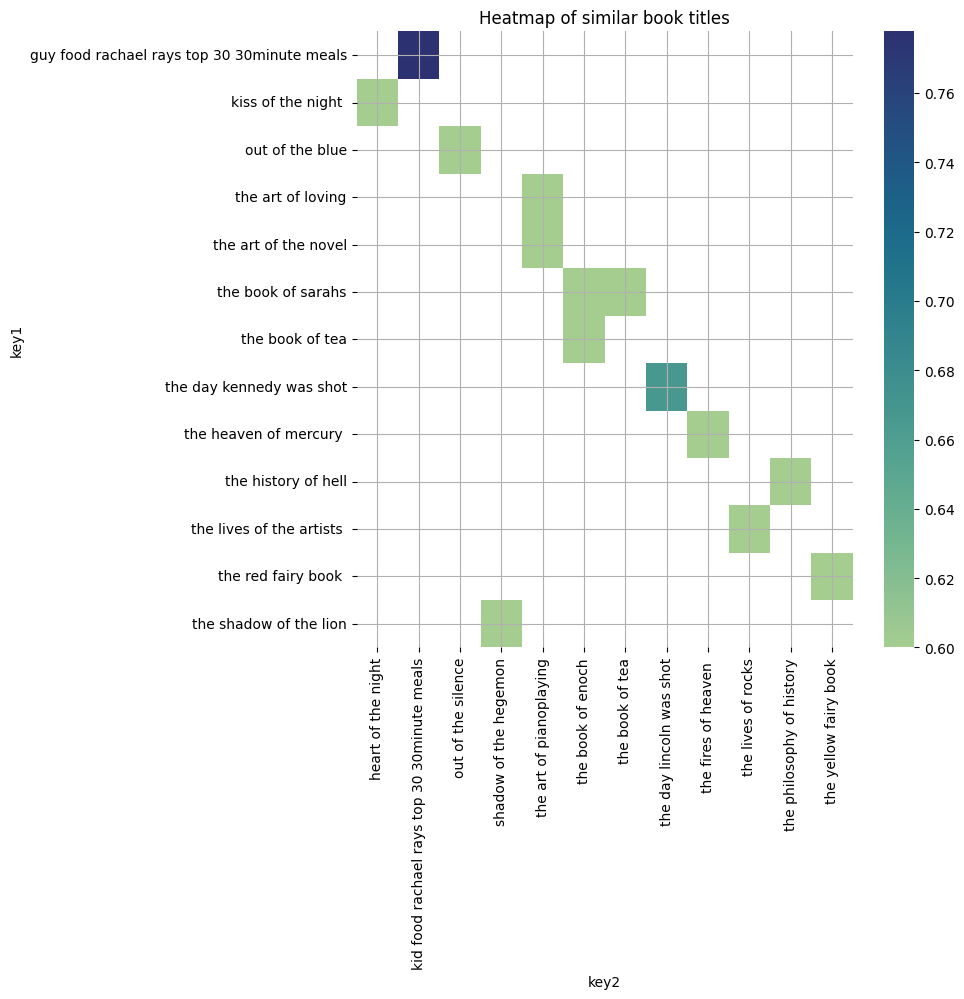

In [27]:
# plot book titles in stead of keys
plt.figure(figsize=(8,8))
found_similar_items_with_lsh_new = {(titles[key1], titles[key2]): value for (key1, key2), value in found_similar_items_with_lsh_new.items()}
plot_heatmap(found_similar_items_with_lsh_new)

## Heatmap based on descriptions


In [28]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lisem_luhqoi7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lisem_luhqoi7\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
def clean_text(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Convert to lowercase
        token = token.lower()
        
        # Remove punctuation
        if token not in string.punctuation:
            # Remove stopwords
            if token not in stopwords.words('english'):
                clean_tokens.append(token)
    
    return clean_tokens

# Transform output into a single string
def clean_text_string(text):
    tokens = word_tokenize(text)
    clean_tokens = []
    
    for token in tokens:
        # Convert to lowercase
        token = token.lower()
        
        # Remove punctuation
        if token not in string.punctuation:
            # Remove stopwords
            if token not in stopwords.words('english'):
                clean_tokens.append(token)

    return ' '.join(clean_tokens)

# Example usage
test = 'This is a test sentence. It contains punctuation!'
print(clean_text_string(test))


test sentence contains punctuation


In [30]:
# Remove where descriptions are nan
books_data_1 = books_data_1.dropna(subset=['description'])
len(books_data_1)

19827

In [31]:
# Take the 200 books with highest n_ratings in a new dataframe
books_data_1 = books_data_1.sort_values('n_ratings', ascending=False)
# Reset index
books_data_2 = books_data_1[0:500].reset_index(drop=True)
len(books_data_2)

500

In [32]:
test = books_data_2['description'][0]
clean_text_string(test)

"celebrate 20 years harry potter magic harry potter never even heard hogwarts letters start dropping doormat number four privet drive addressed green ink yellowish parchment purple seal swiftly confiscated grisly aunt uncle harry 's eleventh birthday great beetle-eyed giant man called rubeus hagrid bursts astonishing news harry potter wizard place hogwarts school witchcraft wizardry incredible adventure begin new editions classic internationally bestselling multi-award-winning series feature instantly pick-up-able new jackets jonny duddle huge child appeal bring harry potter next generation readers 's time pass magic ..."

In [33]:
books_data_2.head()

,title,description,authors,published_date,categories,n_ratings,avg_rating
0,harry potter and the sorcerers stone,Celebrate 20 years of Harry Potter magic! Harr...,['J. K. Rowling'],2014-01-09,['Juvenile Fiction'],3663,4.617544
1,the hobbitt or there and back again illustrate...,"Bilbo Baggins, a respectable, well-to-do hobbi...",['J. R. R. Tolkien'],2013,['Fiction'],3562,4.640625
2,unfit for command swift boat veterans speak ou...,The must-read summary of John E. O’Neill and J...,['BusinessNews Publishing'],2017-01-30,['Political Science'],2962,3.546875
3,rich dad poor dad,Argues that a good education and a secure job ...,['Sharon L. Lechter'],1998,['Business & Economics'],2248,3.690000
4,eragon inheritance book one,One boy . . . One dragon . . . A world of adve...,['Christopher Paolini'],2005,['Dragons'],2134,3.595960


In [34]:
books_data_2['description']

0      Celebrate 20 years of Harry Potter magic! Harr...
1      Bilbo Baggins, a respectable, well-to-do hobbi...
2      The must-read summary of John E. O’Neill and J...
3      Argues that a good education and a secure job ...
4      One boy . . . One dragon . . . A world of adve...
                             ...                        
495    Forced to leave the Clan and her young son, Ay...
496    A Christian evangelist offers a plan for trans...
497    "James Joyce's A Portrait of the Artist as a Y...
498    From the opening line—"Captain Ahab was neithe...
499    When Alex Sennefer's mother uses the Lost Spel...
Name: description, Length: 500, dtype: object

In [35]:
# Apply the clean_text_string function to the description column
books_data_2['description_clean'] = books_data_2['description'].apply(clean_text_string)

In [36]:
# Implement the LSH algorithm
b = 10

def lsh(names, jaccard_threshold,seed):
    lsh_dict = {}
    for key, name in names.to_dict().items():
        blocks = split_k(name,b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}
    for i in range(len(list_keys)-1):
        if i% 500 == 0:
            print(i)
        for j in range(i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(names[list_keys[i]], names[list_keys[j]])
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score
    return similar_items

n = len(books_data_2)

descriptions = books_data_2['description_clean'][0:n]
similar_descriptions = lsh(descriptions,jaccard_threshold=0.1,seed=42)
# Print the results
for (desc1, desc2), score in similar_descriptions.items():
    if score < 1:
        print(f"Similarity Score: {score}")
        print(f"Description 1: {descriptions[desc1]}")
        print(f"Description 2: {descriptions[desc2]}")
        print()

0
Similarity Score: 0.3910761154855643
Description 1: wheel time ® pbs great american read selection development tv since debut 1990 wheel time® robert jordan captivated millions readers around globe scope originality compelling characters wheel time turns ages come go leaving memories become legend legend fades myth even myth long forgotten age gave birth returns third age age prophecy world time hang balance may yet fall shadow fleeing ebou dar kidnapped daughter nine moons fated marry mat cauthon learns neither keep let go safety either shadow might seanchan empire deadly pursuit perrin aybara seeks free wife faile captive shaido hope may alliance enemy remain true friend rand love faile perrin willing sell soul tar valon egwene al'vere young amyrlin rebel aes sedai lays siege heart aes sedai power must win quickly little bloodshed possible unless aes sedai reunited male asha'man remain defend world dark one nothing hold asha'man back total power except aes sedai unified white tower

In [37]:
similar_descriptions_new = {}
# Remove all with jaccard with score 1 from the dictionary similar_descriptions

for (idx1, idx2), score in similar_descriptions.items():
    if score < 1.0:
        similar_descriptions_new[idx1,idx2] = score

similar_descriptions_new

{(8, 121): 0.3910761154855643, (301, 329): 0.24855491329479767}

In [38]:
similar_descriptions_titles = {(books_data_2['title'][key1], books_data_2['title'][key2]): value for (key1, key2), value in similar_descriptions_new.items()}
similar_descriptions_titles

{('crossroads of twilight ', 'knife of dreams '): 0.3910761154855643,
 ('sense and sensibility', 'the pearl'): 0.24855491329479767}

In [39]:
# Plot a heatmap with the found_similar_items_lhs dictionary

# Create a heatmap
def plot_heatmap(found_similar_items_lhs_new):
    # Create a list of keys
    keys = list(found_similar_items_lhs_new.keys())
    
    # Create a list of values
    values = list(found_similar_items_lhs_new.values())
    
    # Create a list of the first items in each key
    key1 = [key[0] for key in keys]
    
    # Create a list of the second items in each key
    key2 = [key[1] for key in keys]
    
    # Create a dataframe with the keys and values
    df = pd.DataFrame({'key1': key1, 'key2': key2, 'values': values})
    
    # Create a pivot table from the dataframe
    df_pivot = df.pivot(index='key1', columns='key2', values='values')
    
    # Create a heatmap from the pivot table
    sns.heatmap(df_pivot, cmap='crest')

    # Add gridlines to the heatmap
    plt.grid()
    
    plt.title('Heatmap of similar book descriptions')

    # Show the plot
    plt.show()


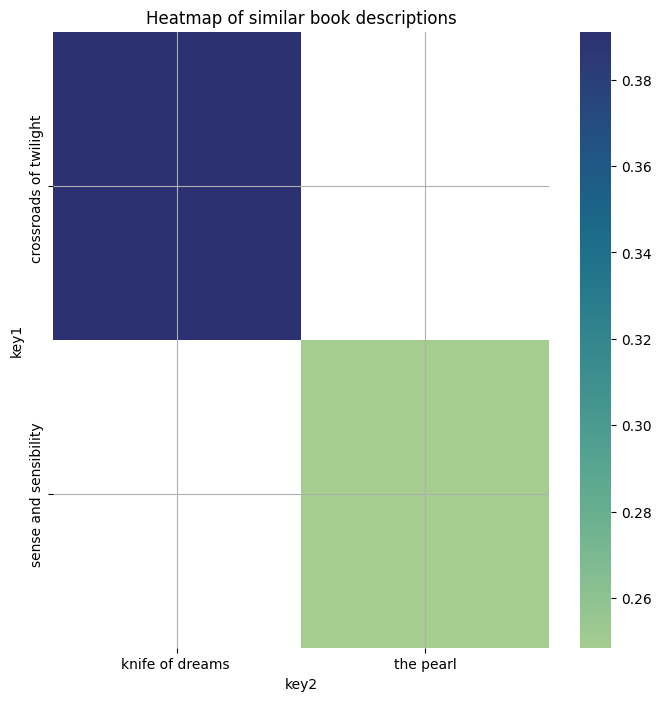

In [40]:
plt.figure(figsize=(8,8))
plot_heatmap(similar_descriptions_titles)

## Histogram of categories

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE


In [42]:
books_data_1['categories']

4590         ['Juvenile Fiction']
773                   ['Fiction']
19711       ['Political Science']
12410    ['Business & Economics']
771                   ['Dragons']
                   ...           
11827                ['Religion']
15697                 ['Fiction']
11831                ['Religion']
11832                 ['Fiction']
16915              ['True Crime']
Name: categories, Length: 19827, dtype: object

In [43]:

# Change dtype of categories to string
# Remove nan from categories
categories = books_data_1['categories'].fillna('').astype(str)
categories = categories.unique()
print(len(categories))
print(categories)
# Find the 10 most frequent categories
# # Crprint(len(categories))


872
["['Juvenile Fiction']" "['Fiction']" "['Political Science']"
 "['Business & Economics']" "['Dragons']" '' "['Young Adult Fiction']"
 "['Self-Help']" "['Literary Criticism']" "['FICTION']" "['Reference']"
 "['History']" "['Computers']" "['Art']" "['Family & Relationships']"
 "['High interest-low vocabulary books']" "['FAMILY & RELATIONSHIPS']"
 "['AReproductive health']" "['Biography & Autobiography']" "['Religion']"
 "['Architects']" "['Predation (Biology)']" "['Humor']" "['True Crime']"
 "['Existential psychotherapy']" "['Executions and executioners']"
 "['Psychology']" "['Social Science']" "['Horror tales']"
 "['Photography']" "['Bullying']" "['Science']" "['Body, Mind & Spirit']"
 "['Cookery, French']" "['Juvenile Nonfiction']" "['Games & Activities']"
 "['Murder']" "['Comics & Graphic Novels']" "['Brothers']"
 "['Philosophy']" "['African Americans']" "['Botswana']"
 "['Intelligence officers']" "['Colombia']" "['American fiction']"
 "['Bibles']" "['Education']" '["Children\'s s

In [44]:
# Find the 10 most frequent categories
from collections import Counter
category_counts = Counter(categories)
#print(category_counts.most_common(10))

# Create a list of the most frequent categories
top_categories = [category for category, count in category_counts.most_common(20)]
print(top_categories)

# Remove nan from top_categories
top_categories = [category for category in top_categories if category != 'nan']
# Remove Fiction from top_categories
top_categories = [category for category in top_categories if category != "['Fiction']"]
top_categories = [category for category in top_categories if category != ""]
print(top_categories)
print(len(top_categories))


["['Juvenile Fiction']", "['Fiction']", "['Political Science']", "['Business & Economics']", "['Dragons']", '', "['Young Adult Fiction']", "['Self-Help']", "['Literary Criticism']", "['FICTION']", "['Reference']", "['History']", "['Computers']", "['Art']", "['Family & Relationships']", "['High interest-low vocabulary books']", "['FAMILY & RELATIONSHIPS']", "['AReproductive health']", "['Biography & Autobiography']", "['Religion']"]
["['Juvenile Fiction']", "['Political Science']", "['Business & Economics']", "['Dragons']", "['Young Adult Fiction']", "['Self-Help']", "['Literary Criticism']", "['FICTION']", "['Reference']", "['History']", "['Computers']", "['Art']", "['Family & Relationships']", "['High interest-low vocabulary books']", "['FAMILY & RELATIONSHIPS']", "['AReproductive health']", "['Biography & Autobiography']", "['Religion']"]
18


In [45]:
books_data_1['top_category'] = books_data_1['categories'] 
books_data_1.head()

,title,description,authors,published_date,categories,n_ratings,avg_rating,top_category
4590,harry potter and the sorcerers stone,Celebrate 20 years of Harry Potter magic! Harr...,['J. K. Rowling'],2014-01-09,['Juvenile Fiction'],3663,4.617544,['Juvenile Fiction']
773,the hobbitt or there and back again illustrate...,"Bilbo Baggins, a respectable, well-to-do hobbi...",['J. R. R. Tolkien'],2013,['Fiction'],3562,4.640625,['Fiction']
19711,unfit for command swift boat veterans speak ou...,The must-read summary of John E. O’Neill and J...,['BusinessNews Publishing'],2017-01-30,['Political Science'],2962,3.546875,['Political Science']
12410,rich dad poor dad,Argues that a good education and a secure job ...,['Sharon L. Lechter'],1998,['Business & Economics'],2248,3.690000,['Business & Economics']
771,eragon inheritance book one,One boy . . . One dragon . . . A world of adve...,['Christopher Paolini'],2005,['Dragons'],2134,3.595960,['Dragons']


In [46]:
top_categories

["['Juvenile Fiction']",
 "['Political Science']",
 "['Business & Economics']",
 "['Dragons']",
 "['Young Adult Fiction']",
 "['Self-Help']",
 "['Literary Criticism']",
 "['FICTION']",
 "['Reference']",
 "['History']",
 "['Computers']",
 "['Art']",
 "['Family & Relationships']",
 "['High interest-low vocabulary books']",
 "['FAMILY & RELATIONSHIPS']",
 "['AReproductive health']",
 "['Biography & Autobiography']",
 "['Religion']"]

In [47]:
books_data_2 = books_data_1.dropna(subset=['categories'])
cats = books_data_2['categories']
# Remove nan from cats
cats.value_counts()

categories
['Fiction']                      5989
['Juvenile Fiction']             1235
['Biography & Autobiography']    1169
['History']                      1086
['Religion']                     1051
                                 ... 
['Atlases']                         1
['Calculus']                        1
['Communism']                       1
['Beagle Expedition']               1
['Change']                          1
Name: count, Length: 871, dtype: int64

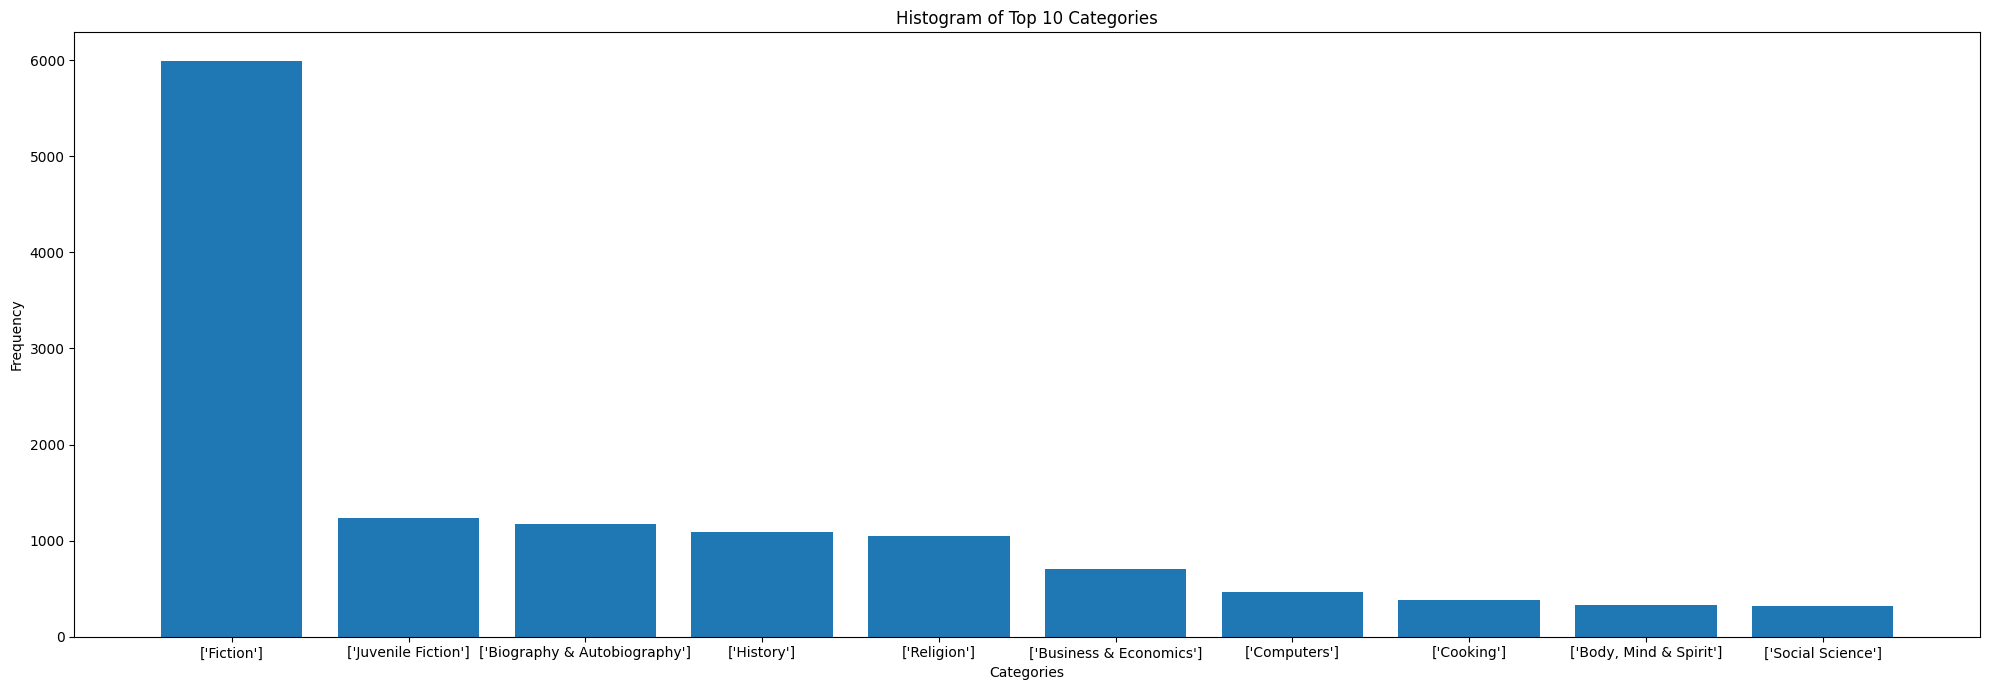

In [48]:

# Make a histogram of the categories

categories_counts = books_data_2['categories'].explode().value_counts()

# Select the top 10 categories
top_categories = categories_counts.head(10)

# Plotting the histogram for the top 10 categories
plt.figure(figsize=(20,7))
plt.bar(top_categories.index, top_categories)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Histogram of Top 10 Categories')
plt.tight_layout()
plt.show()

## Clustering

In [49]:
# Find dtypes of books_data_1
books_data_1.head()

,title,description,authors,published_date,categories,n_ratings,avg_rating,top_category
4590,harry potter and the sorcerers stone,Celebrate 20 years of Harry Potter magic! Harr...,['J. K. Rowling'],2014-01-09,['Juvenile Fiction'],3663,4.617544,['Juvenile Fiction']
773,the hobbitt or there and back again illustrate...,"Bilbo Baggins, a respectable, well-to-do hobbi...",['J. R. R. Tolkien'],2013,['Fiction'],3562,4.640625,['Fiction']
19711,unfit for command swift boat veterans speak ou...,The must-read summary of John E. O’Neill and J...,['BusinessNews Publishing'],2017-01-30,['Political Science'],2962,3.546875,['Political Science']
12410,rich dad poor dad,Argues that a good education and a secure job ...,['Sharon L. Lechter'],1998,['Business & Economics'],2248,3.690000,['Business & Economics']
771,eragon inheritance book one,One boy . . . One dragon . . . A world of adve...,['Christopher Paolini'],2005,['Dragons'],2134,3.595960,['Dragons']


In [50]:
books_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19827 entries, 4590 to 16915
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           19827 non-null  object 
 1   description     19827 non-null  object 
 2   authors         19667 non-null  object 
 3   published_date  19798 non-null  object 
 4   categories      19306 non-null  object 
 5   n_ratings       19827 non-null  int64  
 6   avg_rating      19827 non-null  float64
 7   top_category    19306 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.4+ MB


In [51]:
books_data_1['published_date']


4590     2014-01-09
773            2013
19711    2017-01-30
12410          1998
771            2005
            ...    
11827    2013-07-25
15697    2010-07-07
11831       1992-06
11832       2001-06
16915    2000-03-15
Name: published_date, Length: 19827, dtype: object

In [52]:
# Convert dtype of published_date to datetime from object
books_data_1['published_date'] = pd.to_datetime(books_data_1['published_date'], format='%Y-%m-%d', errors='coerce', utc=True)

In [53]:
books_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19827 entries, 4590 to 16915
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   title           19827 non-null  object             
 1   description     19827 non-null  object             
 2   authors         19667 non-null  object             
 3   published_date  12939 non-null  datetime64[ns, UTC]
 4   categories      19306 non-null  object             
 5   n_ratings       19827 non-null  int64              
 6   avg_rating      19827 non-null  float64            
 7   top_category    19306 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 1.4+ MB


In [54]:
# Make a new column that only contains the year
books_data_1['year'] = books_data_1['published_date'].dt.year

# Delete rows where year is NaT or inf
books_data_2 = books_data_1[books_data_1['year'].notna()]

In [55]:
books_data_2['year'] = books_data_2['year'].astype(int)
books_data_2.head()

C:\Users\lisem_luhqoi7\AppData\Local\Temp\ipykernel_8164\605874599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_data_2['year'] = books_data_2['year'].astype(int)


,title,description,authors,published_date,categories,n_ratings,avg_rating,top_category,year
4590,harry potter and the sorcerers stone,Celebrate 20 years of Harry Potter magic! Harr...,['J. K. Rowling'],2014-01-09 00:00:00+00:00,['Juvenile Fiction'],3663,4.617544,['Juvenile Fiction'],2014
19711,unfit for command swift boat veterans speak ou...,The must-read summary of John E. O’Neill and J...,['BusinessNews Publishing'],2017-01-30 00:00:00+00:00,['Political Science'],2962,3.546875,['Political Science'],2017
4982,the catcher in the rye,Anyone who has read J. D. Salinger's New Yorke...,['J.D. Salinger'],1951-07-16 00:00:00+00:00,['Fiction'],2132,4.050000,['Fiction'],1951
16886,the alchemist a fable about following your dream,The Alchemist by Paulo Coelho | Book Summary |...,"['Billionaire Publishing', '30 Minutes Flip']",2017-01-24 00:00:00+00:00,NaN,1924,3.797203,NaN,2017
1739,the giver,Given his lifetime assignment at the Ceremony ...,['Lois Lowry'],2014-07-01 00:00:00+00:00,['Juvenile Fiction'],1876,4.550847,['Juvenile Fiction'],2014


In [56]:
books_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12939 entries, 4590 to 16915
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   title           12939 non-null  object             
 1   description     12939 non-null  object             
 2   authors         12867 non-null  object             
 3   published_date  12939 non-null  datetime64[ns, UTC]
 4   categories      12579 non-null  object             
 5   n_ratings       12939 non-null  int64              
 6   avg_rating      12939 non-null  float64            
 7   top_category    12579 non-null  object             
 8   year            12939 non-null  int32              
dtypes: datetime64[ns, UTC](1), float64(1), int32(1), int64(1), object(5)
memory usage: 960.3+ KB


C:\Users\lisem_luhqoi7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\lisem_luhqoi7\AppData\Local\Temp\ipykernel_8164\1320091392.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_data_2['cluster'] = kmeans.labels_


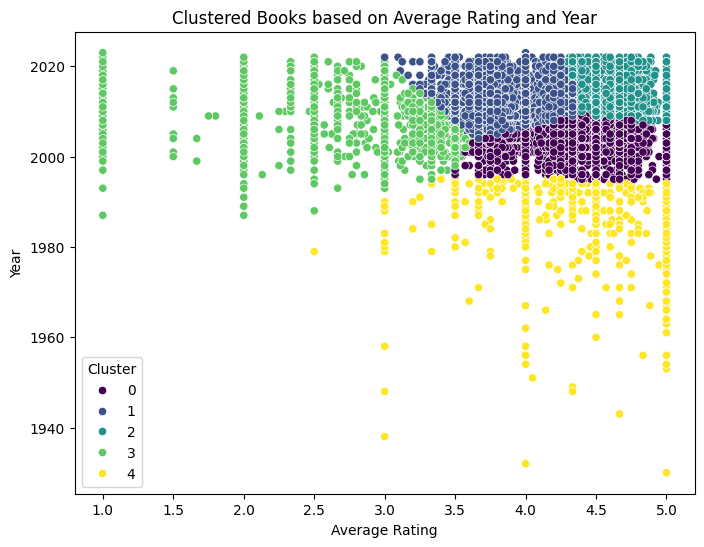

In [57]:
# Cluster books based on avg_rating and year
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
#import matplotlib.pyplot as plt
#import seaborn as sns

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit and transform the data with the scaler
scaled_features = scaler.fit_transform(books_data_2[['avg_rating', 'year']])

# Perform K-Means clustering on the standardized data
kmeans = KMeans(n_clusters=5, random_state=0).fit(scaled_features)

# Add the cluster labels to your DataFrame
books_data_2['cluster'] = kmeans.labels_

# Create a scatter plot of the clusters
plt.figure(figsize=(8, 6))

# Use seaborn to create the scatter plot with different colors for each cluster
sns.scatterplot(x='avg_rating', y='year', data=books_data_2, hue='cluster', palette='viridis')

# Add labels and a legend
plt.xlabel('Average Rating')
plt.ylabel('Year')
plt.title('Clustered Books based on Average Rating and Year')
plt.legend(title='Cluster')

# Show the plot
plt.show()

## Network recommendations

In [60]:
# import librairies
import networkx as nx
#import matplotlib.pyplot as plt
#import pandas as pd
#import numpy as np
import math as math
import time 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.cluster import KMeans

In [ ]:
# Rename dataframe
ratings = books_ratings_1
books = books_data_1

# pick random user
user_id = ratings['user_id'].sample(1).iloc[0]
print(user_id)

test_user = "A126KX6FVI4T66"


In [ ]:
# get n most popular books
n_books= 200
popular_books = ratings['title'].value_counts()[0:n_books].index.tolist()
top_20_books = popular_books[0:20]

# keep only the popular books
popular_books_data = books[books['title'].isin(popular_books)]
popular_books_data = popular_books_data[popular_books_data['description'].notna()]
popular_books_data.reset_index(drop=True, inplace=True)

# get the ratings of the popular books
popular_books_ratings = ratings[ratings['title'].isin(popular_books_data['title'].tolist())]

# reset the index
popular_books_ratings.reset_index(drop=True, inplace=True)

### Recommendations using network-based algorithms

In [ ]:
# Build the tfidf matrix with the descriptions
text_content = popular_books_data['description']
vector = TfidfVectorizer(max_df=0.5,         # drop words that occur in more than X percent of documents
                        min_df=0.05,      # only use words that appear at least X times
                        stop_words='english', # remove stop words
                        lowercase=True, # Convert everything to lower case 
                        use_idf=True,   # Use idf
                        norm=u'l2',     # Normalization
                        smooth_idf=True # Prevents divide-by-zero errors
                        )

tfidf = vector.fit_transform(text_content)
terms = vector.get_feature_names_out()


df_tfidfvect = pd.DataFrame(data = tfidf.toarray(),columns = terms)

# Clustering  Kmeans
k = round(n_books/10)
print("number of clusters: ", k)
kmeans = KMeans(n_clusters = k)
kmeans.fit(tfidf)
centers = np.argsort(kmeans.cluster_centers_, axis=1)[:, ::-1]

#print the centers of the clusters
[print([terms[j] for j in centers[i, :15]]) for i in range(k)]

# convert description to vector
request_transform = vector.transform(popular_books_data['description'])

# assign each book to a cluster
cluster_asign = kmeans.predict(request_transform)

# Save the cluster of each book in the dataframe
popular_books_data['cluster'] = kmeans.predict(request_transform) 


In [ ]:
# check that the cluster are balanced
popular_books_data['cluster'].value_counts()

In [ ]:
# define a function to find 5 most similar books based on the TD-IDF matrix
def find_similar(tfidf_matrix, index, top_n=5):
    cosine_similarities = cosine_similarity(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = sorted(range(len(cosine_similarities)), key=cosine_similarities.__getitem__, reverse=True)
    similar_indices = [i for i in related_docs_indices if i != index][:top_n]
    return similar_indices

In [ ]:
# create the graph
G = nx.Graph()

# construct the graph
for i, rowi in popular_books_data.iterrows():
    # add nodes for the book
    G.add_node(rowi['title'], key=rowi['title'], label="BOOK", rating=rowi['avg_rating'])

    # add nodes for the authors and connect them to the book
    if not G.has_node(rowi['authors']):
        G.add_node(rowi['authors'],label="authors")
    
    # add categories and connect them to the book
    if not G.has_node(rowi['cluster']):
        G.add_node(rowi['cluster'],label="cluster")
    
    # add edges between titles, authors and clusters
    G.add_edge(rowi['title'], rowi['authors'])
    G.add_edge(rowi['cluster'], rowi['title'])
    G.add_edge(rowi['cluster'], rowi['authors'])
    
    # find the 5 most similar books and connect them to the book
    indices = find_similar(tfidf, i, top_n = 5)

    # add edges between the book and the 5 most similar books
    for idx in indices:
        G.add_edge(rowi["title"], popular_books_data['title'].loc[idx], label="SIMILARITY")

In [ ]:
# base node size on avg_rating attribute
sizes = []

# generate a list of colors for the nodes
colors = []
label_vec = {}
for node in G:
    if G.nodes[node]['label'] == "BOOK":
        sizes.append(10*G.nodes[node]['rating'])
        colors.append('red')
        if node in top_20_books:
            label_vec[node] = node
    elif G.nodes[node]['label'] == "authors":
        sizes.append(10)
        colors.append('green')
    else:
        sizes.append(10)
        colors.append('blue')

In [ ]:
# draw the graph
plt.figure(figsize=(15,15))

# use the kamada_kawai_layout to get the nodes positions
pos = nx.kamada_kawai_layout(G)

# draw the nodes and the edges
nx.draw(G,pos =pos, node_size= sizes, node_color = colors, with_labels=False, alpha=0.5, width=0.5, edge_color='grey')
nx.draw_networkx_labels(G,pos,labels=label_vec,font_size=16,font_color='black')
nx.draw_networkx_nodes(G,pos,nodelist=label_vec.keys(),node_size=100,node_color='red', edgecolors='black')

# save the graph
plt.savefig('figs/graph.pdf')
plt.show()

In [ ]:
# define Adaic-Adar function
def adamic_adar_weight(neighbor_list):
    weight = 0.0
    for neighbor in neighbor_list:
        weight += 1 / math.log(G.degree(neighbor))
    return weight

In [ ]:
def get_recommendation(root):
    # Dictionary to store common neighbors and their occurrences
    commons_dict = {}

    # Iterate over neighbors of the root node
    for e in G.neighbors(root):
        # Iterate over neighbors of each neighbor of the root
        for e2 in G.neighbors(e):
            # Skip if the neighbor is the root node
            if e2 == root:
                continue
            
            # Check if the neighbor is a book
            if G.nodes[e2]['label'] == "BOOK":
                commons = commons_dict.get(e2)
                if commons is None:
                    # If the book is not in the dictionary, add it with the current neighbor
                    commons_dict.update({e2: [e]})
                else:
                    # If the book is already in the dictionary, append the current neighbor
                    commons.append(e)
                    commons_dict.update({e2: commons})

    # Lists to store books and their corresponding weights
    books = []
    weight = []

    # Calculate weight for each book based on Adamic-Adar measure
    for key, values in commons_dict.items():
        w = adamic_adar_weight(values)
        books.append(key)
        weight.append(w)

    # Create a pandas Series with book weights and indices
    result = pd.Series(data=np.array(weight), index=books)

    # Sort the Series in descending order based on weights
    result.sort_values(inplace=True, ascending=False)

    return result

In [ ]:
# for user obtain the top 5 books based on what he/she has read

# get the books that the test user has read
user_books = popular_books_ratings[popular_books_ratings['user_id'] == test_user][['title','score']]

# remove duplicate titles
user_books.drop_duplicates(subset=['title'], inplace=True)

# extract titles
user_titles = user_books['title'].unique().tolist()

# get the books that the user has not read
user_unread_books = popular_books_data[~popular_books_data['title'].isin(user_titles)]['title'].unique()

# get recommendations for the user
recommendations = pd.DataFrame(columns=["original", 'title', 'score'])
for book in user_titles:
    rec = get_recommendation(book)
    title = rec.index.tolist()
    for t in title:
        if t not in user_unread_books and t not in recommendations['title'].tolist():
            val = rec.values.tolist()
            new_rec = pd.DataFrame({"original": book, 'title': title, 'score': val})
            recommendations = pd.concat([recommendations, new_rec], ignore_index=True)


# sort the recommendations
recommendations.sort_values(by='score',inplace=True,ascending=False)
recommendations.reset_index(drop=True, inplace=True)

In [ ]:
# make plot of the results
plt.figure()
top_20_titles = recommendations["title"][0:10]

# take only first 10 characters of the title
top_20_titles_short = [t[:30] for t in top_20_titles]

top_20_scores = recommendations["score"][0:10]
plt.bar(top_20_titles_short,top_20_scores, edgecolor = "black", width=0.5)
plt.xlabel('Book')
plt.ylabel('Ademic-Adar Index')
plt.title('Top 20: Recommendation for user ' + str(test_user))

plt.xticks(rotation=90)

# set the layout to tight
plt.savefig('figs/recommendation_test_user.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# check if the books are in the same cluster
print("Check if the recommended books are in the same cluster")
print(popular_books_data.loc[popular_books_data['title'].isin(top_20_books)]["cluster"].value_counts())

# print the cluster of the books that the user has read
print("Cluster of the books that the user has read")
print(popular_books_data.loc[popular_books_data['title'].isin(user_books["title"])]["cluster"].value_counts())


In [ ]:
# draw the graph
plt.figure(figsize=(15,15))

# use the kamada_kawai_layout to get the nodes positions
pos = nx.kamada_kawai_layout(G)

# generate a list of colors for the nodes
colors = []
read_books = {}
rec_books = {}
for node in G:
    if G.nodes[node]['label'] == "BOOK":
        if node in top_20_titles.to_list():
            rec_books[node] = node
        if node in user_books["title"].tolist():
            read_books[node] = node

# create edge list based on the recommendations
edge_list = []
for i in range(0,10):
    edge_list.append((recommendations["original"][i], recommendations["title"][i]))
    
# draw the nodes and the edges
nx.draw(G,pos =pos, node_size= sizes, node_color = colors, with_labels=False, alpha=0.5, width=0.5, edge_color='grey')
nx.draw_networkx_labels(G,pos,labels=read_books,font_size=16,font_color='black')
nx.draw_networkx_nodes(G,pos,nodelist=read_books.keys(),node_size=100,node_color='red', edgecolors='black')
nx.draw_networkx_labels(G,pos,labels=rec_books,font_size=16,font_color='black')
nx.draw_networkx_nodes(G,pos,nodelist=rec_books.keys(),node_size=100,node_color='yellow', edgecolors='black')
nx.draw_networkx_edges(G,pos,edgelist=edge_list,width=5,alpha=0.5,edge_color='blue')
# save the graph
plt.savefig('figs/graph_results.pdf')
plt.show()